# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [47]:
from glob import glob
from typing import Tuple, Callable, Dict
from datetime import datetime
from src.helpers import visualize_one_batch

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import multiprocessing
from tqdm import tqdm

from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision import datasets, transforms
from torch.nn import Module

import tests

In [48]:
data_dir = 'data/' #celeba/'

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

device = torch.device("cuda:0" if (train_on_gpu) else "cpu")

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    torch.cuda.empty_cache()
    print(f'Memory allocated: {torch.cuda.memory_allocated()}')
    print(f'Max memory allocated: {torch.cuda.max_memory_allocated()}')

CUDA is available!  Training on GPU ...
Memory allocated: 177269760
Max memory allocated: 365218816


## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [49]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    
    transforms = [ToTensor()]
    transforms.append(Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]))
    
    return Compose(transforms)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [50]:
class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, 
                 directory: str, 
                 transforms: Callable = None):
                 #extension: str = '.jpg'):
        
        self.images = datasets.ImageFolder(directory,
                                           transform = transforms)

    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        return len(self.images)

    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        return self.images[index][0] # ImageFolder's Image property is a tuple for some reason, so need to also get first element

In [51]:
# """
# DO NOT MODIFY ANYTHING IN THIS CELL
# """
# # run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

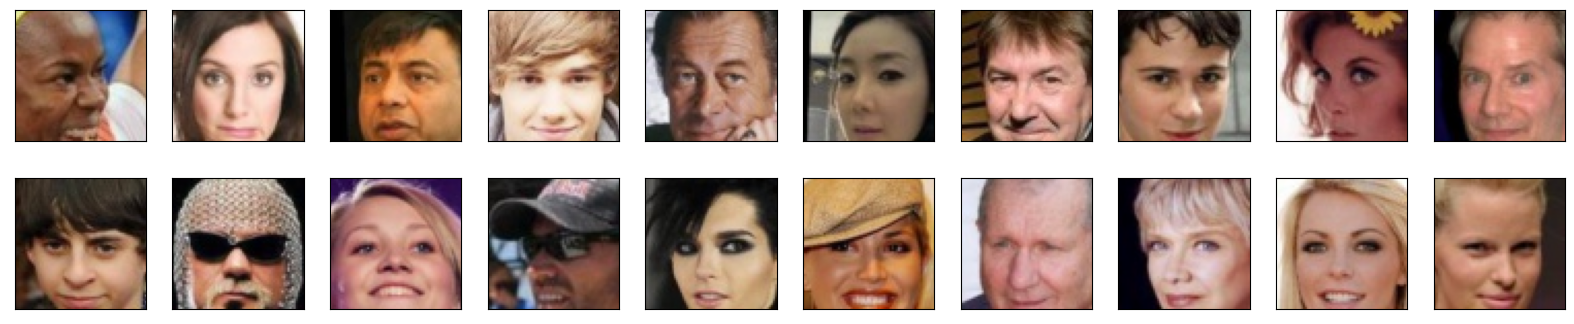

In [52]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    #print(img.shape)
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a G. Now that we have a working data pipeline, we need to implement the discriminator and the G. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the D takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the D.

In [53]:
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    """Helper function to create a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append nn.Conv2d layer
    layers.append(conv_layer)

    # append nn.BatchNorm2d layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
     
    # unpack layers array (iterable object) using nn.Sequential
    return nn.Sequential(*layers)

In [54]:
class Discriminator(Module):
    def __init__(self, conv_dim: int = 32):
        super(Discriminator, self).__init__()
        # complete init function
        self.conv_dim = conv_dim

        # Input shape: (batch_size, 3, 64, 64) - PyTorch optimizes GPUs for channel first dimension of input
        self.conv1 = conv(3, conv_dim, batch_norm=False) # first layer, no batch_norm
        # Output shape after conv1: (batch_size, conv_dim, 32, 32)
        self.conv2 = conv(conv_dim, conv_dim*2)
        # out: (batch_size, conv_dim*2, 16, 16)
        self.conv3 = conv(conv_dim*2, conv_dim*4)
        # out: (batch_size, conv_dim*4, 8, 8)

        # (batch_size, conv_dim*4, 8, 8) in
        self.conv4 = conv(conv_dim*4, conv_dim*8)
        # (batch_size, conv_dim*8, 4, 4) out

        # (batch_size, conv_dim*8, 4, 4) in - (4,4) -> (1,1) spatial dim output
        self.conv5 = conv(conv_dim*8, 1, stride=1, padding=0, batch_norm=False)
        # (batch_size, 1, 1, 1) out - no batch norm as it has errors with spatial dimensions (1,1)

        self.a = nn.LeakyReLU(0.2)     
        #self.fc = nn.Linear(conv_dim*4*4*4, 1)
        #self.last_a = nn.Sigmoid()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # all hidden layers + leaky relu activation
        x = self.a(self.conv1(x))

        x = self.a(self.conv2(x))

        x = self.a(self.conv3(x))

        x = self.a(self.conv4(x))
        #x = self.flatten(x) # flatten seems to only turn [256, 4, 4] tensor to [256, 16] tensor, need [4096]
        #x = x.view(-1, self.conv_dim*4*4*4)
        #x = x.view(x.size(0), -1)
        # final output layer
        #x = self.last_a(self.conv5(x)) - use BCELoss
        x = self.conv5(x) # use BCEWithLogitsLoss
        return x 

In [55]:
# """
# DO NOT MODIFY ANYTHING IN THIS CELL
# """
# # run this cell to check your discriminator implementation
discriminator = Discriminator()
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [56]:
class ApplyNoise(nn.Module):
    """
    Noise injection layer with learnable parameters.
    
    args:
    - channels: number of channels of the input
    """
    def __init__(self, channels: int):
        super(ApplyNoise, self).__init__()
        self.channels = channels
        self.weights = nn.Parameter(torch.zeros(1, channels, 1, 1)).to('cuda')
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        noise = torch.randn(1, 1, x.shape[2], x.shape[3]).to('cuda')
        x = x + self.weights * noise
        return x
    
class AdaIN(nn.Module):
    """
    Adaptive Instance Normalization layer
    
    args:
    - channels: number of channels of the input
    - w_dim: dimension of the latent vector w
    
    inputs:
    - x: float32 tensor of dim [N, C, H, W]
    - w: float32 tensor of dim [N, W_DIM]
    """
    def __init__(self, channels: int, w_dim: int):
        super(AdaIN, self).__init__()
        self.channels = channels
        self.w_dim = w_dim
        self.instance_norm  = nn.InstanceNorm2d(channels)
        self.linear_s = nn.Linear(w_dim, channels)
        self.linear_b = nn.Linear(w_dim, channels)
        
    def forward(self, x: torch.Tensor, w: torch.Tensor) -> torch.Tensor:
        x = self.instance_norm(x)       
        ys = self.linear_s(w)[..., None, None]
        yb = self.linear_b(w)[..., None, None]
        return x * ys + yb

In [57]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True, apply_noise=False):
    """Helper function to create a transposed-convolutional layer, with optional batch normalization.
    """
    layers = []
    deconv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append nn.ConvTranspose2d layer
    layers.append(deconv_layer)

    # append ApplyNoise nn.Module layer to add random noise from normal distribution
    # not clear if do before or after conv transpose2d and batch norm
    if apply_noise:
        layers.append(ApplyNoise(out_channels))

    # append nn.BatchNorm2d layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
     
    # unpack layers array (iterable object) using nn.Sequential
    return nn.Sequential(*layers)

In [58]:
class Generator(Module):
    def __init__(self, latent_dim: int, conv_dim: int = 32):
        super(Generator, self).__init__()
        self.conv_dim = conv_dim

        self.fc1 = nn.Linear(latent_dim, conv_dim*4*4*4)

        # kernel of size 4x4, stride of 1, padding 0 to upsample the input tensor while maintaining its spatial dimensions
        # Input shape: (batch_size, latent_dim, 1, 1) - input noise tensor, z
        self.deconv1 = deconv(latent_dim, conv_dim*16, stride=1, padding=0) #(latent_dim, conv_dim*16 #(latent_dim, conv_dim*8
        # In: (batch_size, latent_dim*16, 4, 4)
        self.deconv2 = deconv(conv_dim*16, conv_dim*8)
        # In: (batch_size, latent_dim*8, 8, 8)
        self.deconv3 = deconv(conv_dim*8, conv_dim*4)

        # In: (batch_size, latent_dim*4, 16, 16)
        self.deconv4 = deconv(conv_dim*4, conv_dim*2)

        # In: (batch_size, latent_dim*2, 32, 32)
        self.deconv5 = deconv(conv_dim*2, 3, batch_norm=False)
        # Out: (batch_size, 3, 64, 64)

        self.a = nn.ReLU()
        self.last_a = nn.Tanh()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.to(device)

        # x = self.fc1(x)
        # x = x.view(-1, self.conv_dim*4, 4, 4)
        x = self.a(self.deconv1(x))
        x = self.a(self.deconv2(x))
        x = self.a(self.deconv3(x))
        x = self.a(self.deconv4(x))
        x = self.last_a(self.deconv5(x))
        return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Congrats, your generator implementation passed all the tests


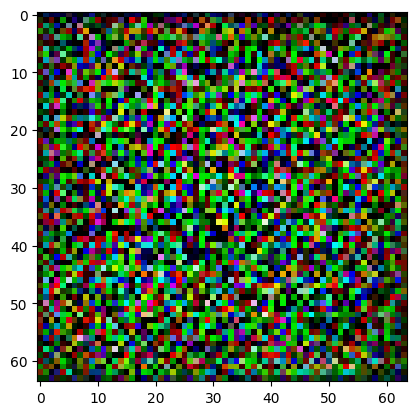

In [59]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
latent_vector = torch.randn(64, latent_dim, 1, 1).float().cuda()
G = Generator(latent_dim).to('cuda')
fake_images = G(latent_vector)
img = fake_images[0].cpu().detach()
image_array = img.permute(1, 2, 0).numpy()
plt.imshow(image_array)
tests.check_generator(G, latent_dim)

In [60]:
# custom weights initialization called on ``G`` and ``D`` - from PyTorch
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1: # If layer contains 'Conv' initialize to 0 mean and 0.02 std. dev
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1: # If layer contains 'BatchNorm' initialize to 1.0 mean and 0.02 std. dev
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0) # biases initialized to 0

## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [61]:
def create_optimizers(G: Module, D: Module):
    """ This function should return the optimizers of the generator and the discriminator """
    # Hyperparameters from PyTorch documentation
    lr = 0.002
    beta1 = 0.5
    beta2 = 0.999

    g_optimizer = optim.Adam(G.parameters(), lr=lr, betas=[beta1, beta2])
    d_optimizer = optim.Adam(D.parameters(), lr=lr, betas=[beta1, beta2])
    # g_optimizer = optim.RMSprop(G.parameters(), lr=0.001, weight_decay=1e-8)
    # d_optimizer = optim.RMSprop(D.parameters(), lr=0.001, weight_decay=1e-8)
    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [62]:
# PyTorch Documentation - uses the BCELoss function - only do if also doing Sigmoid at end of D**
#criterion = nn.BCELoss()
# binary cross entropy with logits loss
# NOTE: BCEWithLogitsLoss combines the sigmoid activation and binary cross-entropy loss into a single operation
# it expects raw logits (unnormalized scores) from D, not probabilities, so no Sigmoid at end of D
criterion = nn.BCEWithLogitsLoss()

def generator_loss(d_logits, smooth=False):
    """ Generator/Real loss, takes the discriminator scores as inputs. This is also known as the Real loss, because
    it is the loss w.r.t. how well the Generator tricks the Discriminator that its generated (fake) images are real"""
    # get batch size so real_labels is same size as discriminator output, d_logits (batch_size, 1)
    batch_size = d_logits.size(0)

    if smooth:
        # smooth, real labels = 0.9 w.r.t generator, should be close to 1
        real_labels = torch.ones(batch_size)*0.9
    else:
        real_labels = torch.ones(batch_size) # real labels = 1

    # use the real labels as GT labels for the loss function, as this allows us to use the log(x) part of the BCELoss 
    # (rather than minimizing the log(1−x) part)
    real_labels = real_labels.to(device)
    # calculate loss - loss function expects shape (batch_size,), remove extra dim
    loss = criterion(d_logits.squeeze(), real_labels)

    return loss

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [63]:
def wasserstein_loss(real_logits, fake_logits, lambda_gp, penalty):
    """ Discriminator loss, takes the fake and real logits as inputs. """
    # batch_size = fake_logits.size(0)
    # # smooth, real labels = 0.9 w.r.t discriminator, should be close to 1
    # real_labels = torch.ones(batch_size).cuda()
    # fake_labels = torch.zeros(batch_size).cuda()

    #wasserstein_loss = (torch.mean(fake_logits * fake_labels) - torch.mean(real_logits * real_labels)) + lambda_gp * penalty
    wasserstein_loss = (torch.mean(fake_logits) - torch.mean(real_logits)) + lambda_gp * penalty

    return wasserstein_loss

# Define the label smoothing loss function
#criterion/adversarial_loss = nn.BCELoss()

def discriminator_loss(real_logits, fake_logits, smooth=False):
    """ Discriminator loss, takes the fake and real logits as inputs. """
    # Create labels for real and fake samples
    if smooth:
        real_labels = torch.ones_like(real_logits) * 0.9
    else:
        real_labels = torch.ones_like(real_logits)
    fake_labels = torch.zeros_like(fake_logits).to(device)

    #label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

    # Calculate the adversarial loss for real and fake samples
    real_loss = criterion(real_logits, real_labels.to(device))
    fake_loss = criterion(fake_logits, fake_labels)

    # Calculate the total discriminator loss
    loss = real_loss + fake_loss

    return loss

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [64]:
def gradient_penalty(D, real_samples, fake_samples):
    """ This function enforces that the norm of the gradient is bounded by 1"""
    
    # sample a random point between both distributions
    alpha = torch.rand(real_samples.shape).cuda()
    # interpolation
    x_hat = alpha * real_samples + (1 - alpha) * fake_samples
    
    # Detach x_hat to make it a leaf variable (so we can set requires_grad to true)
    x_hat = x_hat.detach()
    # calculate the gradient
    x_hat.requires_grad = True
    # Image is [3, 64, 64] tensor, need to add dummy batch dimension to have FC layer work
    #x_hat = x_hat.unsqueeze(0)
    pred = D(x_hat)
    grad = torch.autograd.grad(pred, 
                            x_hat, 
                            grad_outputs=torch.ones_like(pred), 
                            create_graph=True)[0]
    
    # calculate the norm and the final penalty
    norm = torch.norm(grad.view(-1), 2)
    gp = ((norm - 1)**2).mean()

    return gp

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [65]:
def generator_step(batch_size: int, latent_dim: int, D: Module, G: Module, g_optimizer: optim.Optimizer) -> Dict:
    """ One training step of the generator. """
    g_optimizer.zero_grad()

    # generate new sample
    z = torch.randn(batch_size, latent_dim, 1, 1).float() #.cuda()
    #z = np.random.uniform(-1, 1, size=(batch_size, z_size))
    #z = torch.from_numpy(z).float()
    if train_on_gpu:
        z = z.cuda()
    fake_images = G(z)
    # run discriminator again
    fake_logits = D(fake_images)

    loss = generator_loss(fake_logits)
    g_loss = loss
    loss.backward()
    g_optimizer.step()
    return g_loss.item()

def discriminator_step(batch_size: int, latent_dim: int, real_images: torch.Tensor, D: Module, G: Module, d_optimizer: optim.Optimizer) -> Dict:
    """ One training step of the discriminator. """
    z = torch.randn(batch_size, latent_dim, 1, 1).float().cuda()
    generated_images = G(z)
    # Backward pass and update the discriminator parameters
    d_optimizer.zero_grad()

    # Compute the discriminator's predictions for real and fake data
    real_predictions = D(real_images)
    fake_predictions = D(generated_images.detach())

    gp = gradient_penalty(D, real_images, generated_images)
    lambda_gp = 0.2
    loss = wasserstein_loss(real_predictions, fake_predictions, lambda_gp, gp)
    #loss = discriminator_loss(real_predictions, fake_predictions)
    d_loss = loss
    loss.backward()
    d_optimizer.step()
    return d_loss.item()

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [66]:
# you can experiment with different dimensions of latent spaces
latent_dim = 64

# update to cpu if you do not have access to a gpu
device = 'cuda'

# number of epochs to train your model
n_epochs = 10

# number of images in each batch
batch_size = 64

# hyperparameter alpha for the gradient penalty
lambda_gp = 0.2 #10

In [ ]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50

# Create optimizers for the discriminator D and generator G
G = Generator(latent_dim).to(device)
D = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02
G.apply(weights_init)
D.apply(weights_init)

g_optimizer, d_optimizer = create_optimizers(G, D)

datatransform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ])
# Create train and validation datasets
dataset1 = datasets.ImageFolder(
        data_dir,
        transform = datatransform
    )

dataloader = DataLoader(dataset1,
                        batch_size=batch_size, 
                        shuffle=True,
                        num_workers=4,
                        drop_last=True,
                        pin_memory=False)

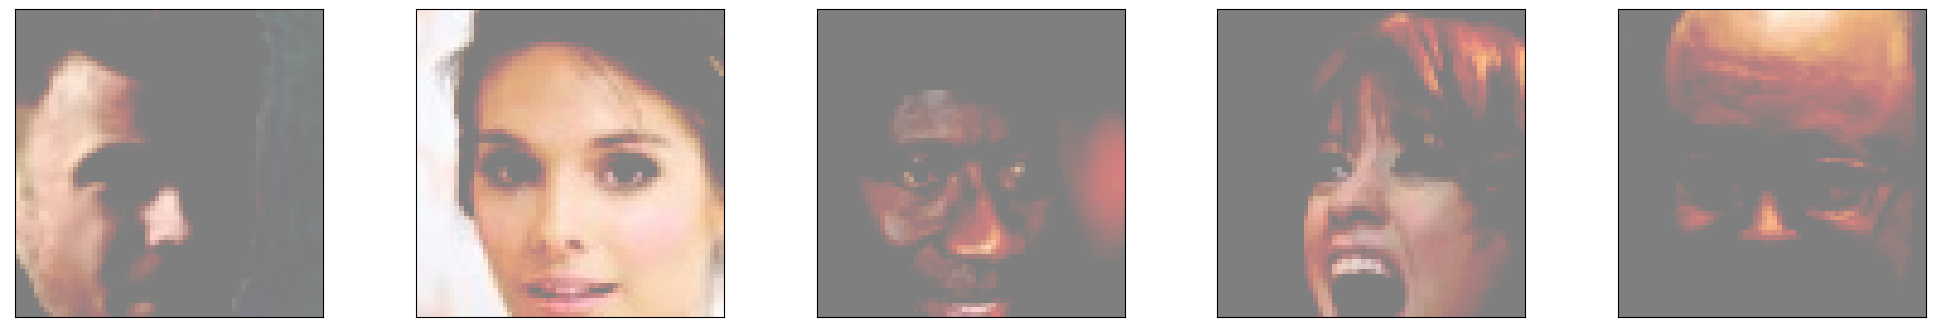

In [68]:
real_images = visualize_one_batch(dataloader)
real_images = real_images.to(device)

In [69]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

Epoch 0


Training:   1%|▎                                | 4/381 [00:00<00:30, 12.36it/s]

2025-01-15 17:41:57 | Epoch [1/10] | Batch 0/381 | d_loss: 1.4172 | g_loss: 14.4045


Training:  14%|████▌                           | 55/381 [00:02<00:12, 25.79it/s]

2025-01-15 17:41:59 | Epoch [1/10] | Batch 50/381 | d_loss: 1.6423 | g_loss: 1.4293


Training:  28%|████████▌                      | 106/381 [00:04<00:10, 26.07it/s]

2025-01-15 17:42:01 | Epoch [1/10] | Batch 100/381 | d_loss: 1.1888 | g_loss: 1.8489


Training:  40%|████████████▌                  | 154/381 [00:06<00:08, 26.24it/s]

2025-01-15 17:42:03 | Epoch [1/10] | Batch 150/381 | d_loss: 1.2705 | g_loss: 1.3008


Training:  54%|████████████████▋              | 205/381 [00:08<00:06, 25.58it/s]

2025-01-15 17:42:05 | Epoch [1/10] | Batch 200/381 | d_loss: 1.2615 | g_loss: 1.1860


Training:  67%|████████████████████▊          | 256/381 [00:10<00:04, 26.09it/s]

2025-01-15 17:42:07 | Epoch [1/10] | Batch 250/381 | d_loss: 1.4745 | g_loss: 1.0958


Training:  80%|████████████████████████▋      | 304/381 [00:11<00:02, 25.74it/s]

2025-01-15 17:42:09 | Epoch [1/10] | Batch 300/381 | d_loss: 3.2001 | g_loss: 3.9342


Training:  93%|████████████████████████████▉  | 355/381 [00:13<00:01, 25.67it/s]

2025-01-15 17:42:11 | Epoch [1/10] | Batch 350/381 | d_loss: 0.9225 | g_loss: 1.2535


Training: 100%|███████████████████████████████| 381/381 [00:15<00:00, 25.27it/s]


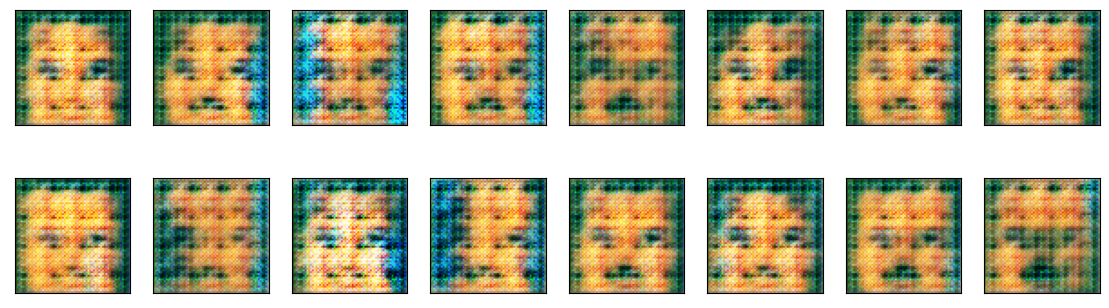

Epoch 1


Training:   1%|▎                                | 4/381 [00:00<00:31, 12.01it/s]

2025-01-15 17:42:16 | Epoch [2/10] | Batch 0/381 | d_loss: 1.5230 | g_loss: 1.6680


Training:  14%|████▌                           | 55/381 [00:02<00:12, 26.01it/s]

2025-01-15 17:42:18 | Epoch [2/10] | Batch 50/381 | d_loss: 1.8588 | g_loss: 3.7767


Training:  28%|████████▌                      | 106/381 [00:04<00:10, 25.60it/s]

2025-01-15 17:42:20 | Epoch [2/10] | Batch 100/381 | d_loss: 1.4450 | g_loss: 2.0085


Training:  40%|████████████▌                  | 154/381 [00:06<00:08, 25.64it/s]

2025-01-15 17:42:22 | Epoch [2/10] | Batch 150/381 | d_loss: 1.4516 | g_loss: 1.8148


Training:  54%|████████████████▋              | 205/381 [00:08<00:06, 25.62it/s]

2025-01-15 17:42:24 | Epoch [2/10] | Batch 200/381 | d_loss: 0.9405 | g_loss: 1.7693


Training:  67%|████████████████████▊          | 256/381 [00:10<00:04, 26.00it/s]

2025-01-15 17:42:26 | Epoch [2/10] | Batch 250/381 | d_loss: 1.3990 | g_loss: 1.8500


Training:  80%|████████████████████████▋      | 304/381 [00:11<00:03, 25.61it/s]

2025-01-15 17:42:28 | Epoch [2/10] | Batch 300/381 | d_loss: 1.3542 | g_loss: 1.0806


Training:  93%|████████████████████████████▉  | 355/381 [00:13<00:01, 25.35it/s]

2025-01-15 17:42:30 | Epoch [2/10] | Batch 350/381 | d_loss: 0.9918 | g_loss: 1.5557


Training: 100%|███████████████████████████████| 381/381 [00:15<00:00, 25.22it/s]


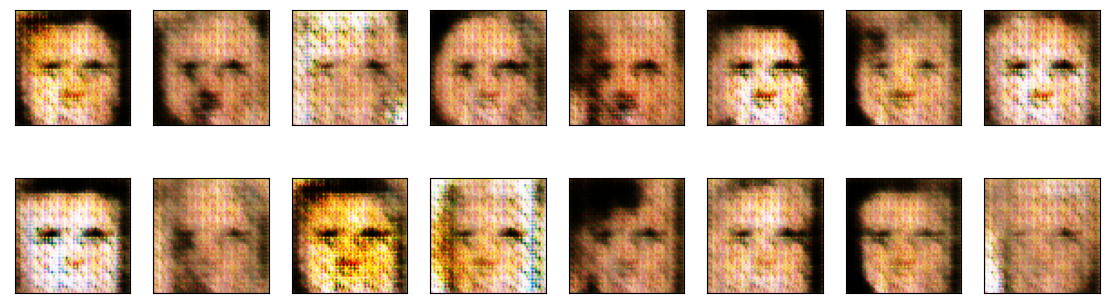

Epoch 2


Training:   1%|▎                                | 4/381 [00:00<00:31, 12.09it/s]

2025-01-15 17:42:35 | Epoch [3/10] | Batch 0/381 | d_loss: 0.8489 | g_loss: 1.6546


Training:  14%|████▌                           | 55/381 [00:02<00:12, 25.96it/s]

2025-01-15 17:42:37 | Epoch [3/10] | Batch 50/381 | d_loss: 1.1279 | g_loss: 2.2610


Training:  28%|████████▌                      | 106/381 [00:04<00:10, 26.09it/s]

2025-01-15 17:42:39 | Epoch [3/10] | Batch 100/381 | d_loss: 1.2712 | g_loss: 1.1611


Training:  40%|████████████▌                  | 154/381 [00:06<00:08, 25.98it/s]

2025-01-15 17:42:41 | Epoch [3/10] | Batch 150/381 | d_loss: 1.1167 | g_loss: 1.9866


Training:  54%|████████████████▋              | 205/381 [00:08<00:06, 25.63it/s]

2025-01-15 17:42:43 | Epoch [3/10] | Batch 200/381 | d_loss: 1.1565 | g_loss: 1.7241


Training:  67%|████████████████████▊          | 256/381 [00:10<00:04, 25.47it/s]

2025-01-15 17:42:45 | Epoch [3/10] | Batch 250/381 | d_loss: 0.9044 | g_loss: 1.5655


Training:  80%|████████████████████████▋      | 304/381 [00:12<00:02, 25.99it/s]

2025-01-15 17:42:47 | Epoch [3/10] | Batch 300/381 | d_loss: 1.0285 | g_loss: 2.1839


Training:  93%|████████████████████████████▉  | 355/381 [00:13<00:01, 25.96it/s]

2025-01-15 17:42:49 | Epoch [3/10] | Batch 350/381 | d_loss: 1.0943 | g_loss: 1.6412


Training: 100%|███████████████████████████████| 381/381 [00:15<00:00, 25.14it/s]


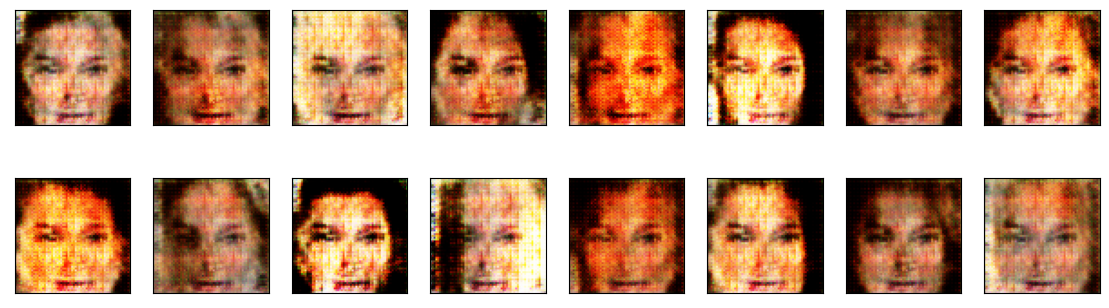

Epoch 3


Training:   1%|▎                                | 3/381 [00:00<00:43,  8.76it/s]

2025-01-15 17:42:54 | Epoch [4/10] | Batch 0/381 | d_loss: 2.0093 | g_loss: 1.4749


Training:  14%|████▌                           | 54/381 [00:02<00:12, 25.85it/s]

2025-01-15 17:42:56 | Epoch [4/10] | Batch 50/381 | d_loss: 0.9409 | g_loss: 1.7435


Training:  28%|████████▌                      | 105/381 [00:04<00:10, 25.53it/s]

2025-01-15 17:42:58 | Epoch [4/10] | Batch 100/381 | d_loss: 1.1635 | g_loss: 0.9920


Training:  41%|████████████▋                  | 156/381 [00:06<00:08, 25.42it/s]

2025-01-15 17:43:00 | Epoch [4/10] | Batch 150/381 | d_loss: 1.0402 | g_loss: 1.2628


Training:  54%|████████████████▌              | 204/381 [00:08<00:06, 26.24it/s]

2025-01-15 17:43:02 | Epoch [4/10] | Batch 200/381 | d_loss: 1.1521 | g_loss: 1.7565


Training:  67%|████████████████████▋          | 255/381 [00:10<00:04, 25.80it/s]

2025-01-15 17:43:04 | Epoch [4/10] | Batch 250/381 | d_loss: 1.4194 | g_loss: 1.7360


Training:  80%|████████████████████████▉      | 306/381 [00:12<00:02, 25.98it/s]

2025-01-15 17:43:06 | Epoch [4/10] | Batch 300/381 | d_loss: 2.0415 | g_loss: 2.1412


Training:  93%|████████████████████████████▊  | 354/381 [00:14<00:01, 25.75it/s]

2025-01-15 17:43:08 | Epoch [4/10] | Batch 350/381 | d_loss: 1.0094 | g_loss: 1.6756


Training: 100%|███████████████████████████████| 381/381 [00:15<00:00, 25.04it/s]


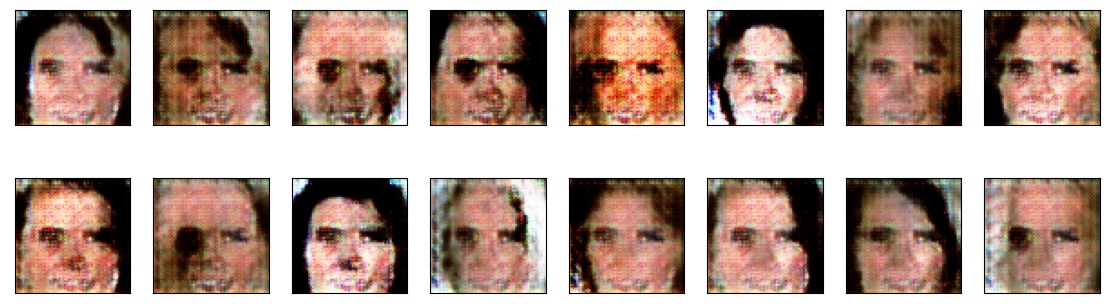

Epoch 4


Training:   1%|▎                                | 4/381 [00:00<00:32, 11.67it/s]

2025-01-15 17:43:13 | Epoch [5/10] | Batch 0/381 | d_loss: 1.7962 | g_loss: 2.0990


Training:  14%|████▌                           | 55/381 [00:02<00:12, 25.61it/s]

2025-01-15 17:43:15 | Epoch [5/10] | Batch 50/381 | d_loss: 1.2364 | g_loss: 2.7929


Training:  28%|████████▌                      | 106/381 [00:04<00:10, 25.86it/s]

2025-01-15 17:43:17 | Epoch [5/10] | Batch 100/381 | d_loss: 1.1785 | g_loss: 1.7083


Training:  40%|████████████▌                  | 154/381 [00:06<00:08, 26.17it/s]

2025-01-15 17:43:19 | Epoch [5/10] | Batch 150/381 | d_loss: 0.9894 | g_loss: 1.8263


Training:  54%|████████████████▋              | 205/381 [00:08<00:06, 26.00it/s]

2025-01-15 17:43:21 | Epoch [5/10] | Batch 200/381 | d_loss: 1.3239 | g_loss: 2.6514


Training:  67%|████████████████████▊          | 256/381 [00:10<00:04, 26.14it/s]

2025-01-15 17:43:23 | Epoch [5/10] | Batch 250/381 | d_loss: 1.1471 | g_loss: 1.8860


Training:  80%|████████████████████████▋      | 304/381 [00:12<00:02, 26.56it/s]

2025-01-15 17:43:25 | Epoch [5/10] | Batch 300/381 | d_loss: 2.1399 | g_loss: 3.0240


Training:  93%|████████████████████████████▉  | 355/381 [00:13<00:00, 26.22it/s]

2025-01-15 17:43:27 | Epoch [5/10] | Batch 350/381 | d_loss: 1.2872 | g_loss: 2.9739


Training: 100%|███████████████████████████████| 381/381 [00:15<00:00, 25.27it/s]


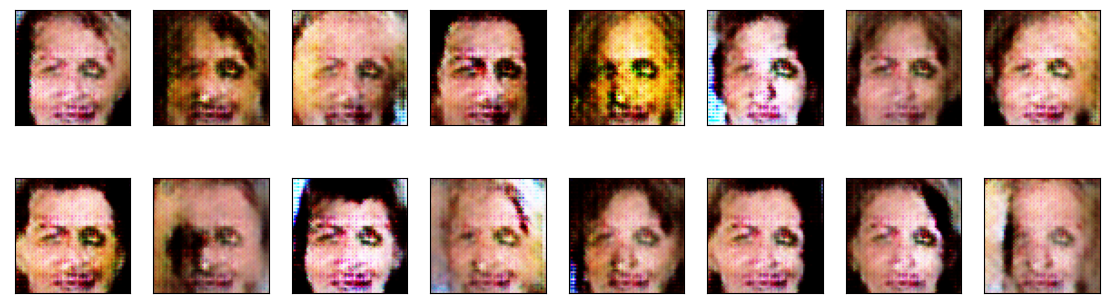

Epoch 5


Training:   1%|▎                                | 4/381 [00:00<00:27, 13.48it/s]

2025-01-15 17:43:33 | Epoch [6/10] | Batch 0/381 | d_loss: 1.2588 | g_loss: 1.6752


Training:  14%|████▌                           | 55/381 [00:02<00:12, 26.65it/s]

2025-01-15 17:43:34 | Epoch [6/10] | Batch 50/381 | d_loss: 0.8012 | g_loss: 1.7561


Training:  28%|████████▌                      | 106/381 [00:04<00:10, 26.94it/s]

2025-01-15 17:43:36 | Epoch [6/10] | Batch 100/381 | d_loss: 0.8750 | g_loss: 1.8899


Training:  40%|████████████▌                  | 154/381 [00:05<00:08, 26.50it/s]

2025-01-15 17:43:38 | Epoch [6/10] | Batch 150/381 | d_loss: 1.1684 | g_loss: 1.9259


Training:  54%|████████████████▋              | 205/381 [00:07<00:06, 26.39it/s]

2025-01-15 17:43:40 | Epoch [6/10] | Batch 200/381 | d_loss: 1.0036 | g_loss: 1.9496


Training:  67%|████████████████████▊          | 256/381 [00:09<00:04, 26.46it/s]

2025-01-15 17:43:42 | Epoch [6/10] | Batch 250/381 | d_loss: 1.3221 | g_loss: 2.4396


Training:  80%|████████████████████████▋      | 304/381 [00:11<00:02, 26.63it/s]

2025-01-15 17:43:44 | Epoch [6/10] | Batch 300/381 | d_loss: 0.8082 | g_loss: 1.8977


Training:  93%|████████████████████████████▉  | 355/381 [00:13<00:00, 26.55it/s]

2025-01-15 17:43:46 | Epoch [6/10] | Batch 350/381 | d_loss: 1.0532 | g_loss: 1.9172


Training: 100%|███████████████████████████████| 381/381 [00:14<00:00, 25.88it/s]


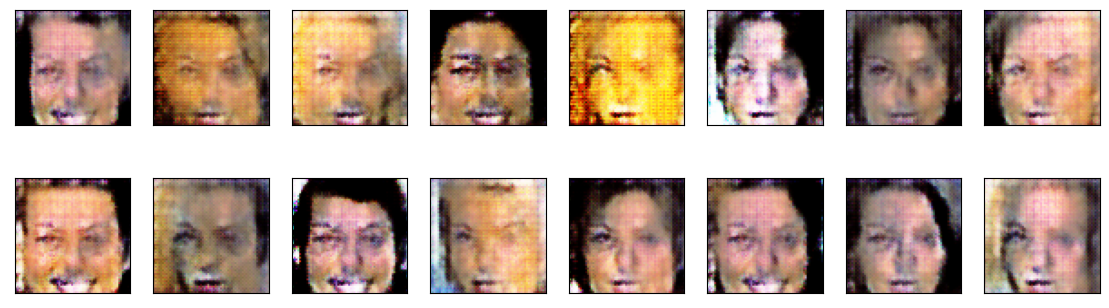

Epoch 6


Training:   1%|▎                                | 4/381 [00:00<00:30, 12.21it/s]

2025-01-15 17:43:51 | Epoch [7/10] | Batch 0/381 | d_loss: 1.1420 | g_loss: 1.8932


Training:  14%|████▌                           | 55/381 [00:02<00:12, 26.51it/s]

2025-01-15 17:43:53 | Epoch [7/10] | Batch 50/381 | d_loss: 1.2530 | g_loss: 2.0547


Training:  28%|████████▌                      | 106/381 [00:04<00:10, 26.30it/s]

2025-01-15 17:43:55 | Epoch [7/10] | Batch 100/381 | d_loss: 1.2050 | g_loss: 1.9215


Training:  40%|████████████▌                  | 154/381 [00:06<00:08, 27.00it/s]

2025-01-15 17:43:57 | Epoch [7/10] | Batch 150/381 | d_loss: 1.2803 | g_loss: 1.9287


Training:  54%|████████████████▋              | 205/381 [00:07<00:06, 26.92it/s]

2025-01-15 17:43:59 | Epoch [7/10] | Batch 200/381 | d_loss: 0.7924 | g_loss: 2.0568


Training:  67%|████████████████████▊          | 256/381 [00:09<00:04, 26.88it/s]

2025-01-15 17:44:01 | Epoch [7/10] | Batch 250/381 | d_loss: 0.9993 | g_loss: 1.9997


Training:  81%|████████████████████████▉      | 307/381 [00:11<00:02, 27.52it/s]

2025-01-15 17:44:03 | Epoch [7/10] | Batch 300/381 | d_loss: 1.3578 | g_loss: 1.3926


Training:  93%|████████████████████████████▉  | 355/381 [00:13<00:00, 26.62it/s]

2025-01-15 17:44:04 | Epoch [7/10] | Batch 350/381 | d_loss: 1.2514 | g_loss: 1.1727


Training: 100%|███████████████████████████████| 381/381 [00:14<00:00, 25.99it/s]


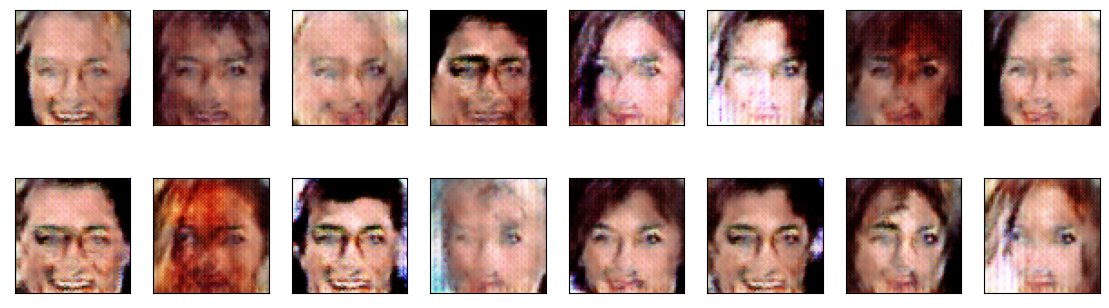

Epoch 7


Training:   1%|▎                                | 4/381 [00:00<00:30, 12.32it/s]

2025-01-15 17:44:10 | Epoch [8/10] | Batch 0/381 | d_loss: 1.2728 | g_loss: 1.4914


Training:  14%|████▌                           | 55/381 [00:02<00:12, 26.76it/s]

2025-01-15 17:44:12 | Epoch [8/10] | Batch 50/381 | d_loss: 1.8483 | g_loss: 1.9048


Training:  28%|████████▌                      | 106/381 [00:04<00:10, 27.25it/s]

2025-01-15 17:44:14 | Epoch [8/10] | Batch 100/381 | d_loss: 0.8201 | g_loss: 1.7757


Training:  40%|████████████▌                  | 154/381 [00:05<00:08, 27.07it/s]

2025-01-15 17:44:16 | Epoch [8/10] | Batch 150/381 | d_loss: 1.0860 | g_loss: 2.0715


Training:  54%|████████████████▋              | 205/381 [00:07<00:06, 27.05it/s]

2025-01-15 17:44:18 | Epoch [8/10] | Batch 200/381 | d_loss: 1.2808 | g_loss: 1.9123


Training:  67%|████████████████████▊          | 256/381 [00:09<00:04, 27.13it/s]

2025-01-15 17:44:19 | Epoch [8/10] | Batch 250/381 | d_loss: 1.0790 | g_loss: 2.7592


Training:  81%|████████████████████████▉      | 307/381 [00:11<00:02, 27.35it/s]

2025-01-15 17:44:21 | Epoch [8/10] | Batch 300/381 | d_loss: 1.3243 | g_loss: 1.5360


Training:  93%|████████████████████████████▉  | 355/381 [00:13<00:00, 27.20it/s]

2025-01-15 17:44:23 | Epoch [8/10] | Batch 350/381 | d_loss: 0.9913 | g_loss: 1.6542


Training: 100%|███████████████████████████████| 381/381 [00:14<00:00, 26.21it/s]


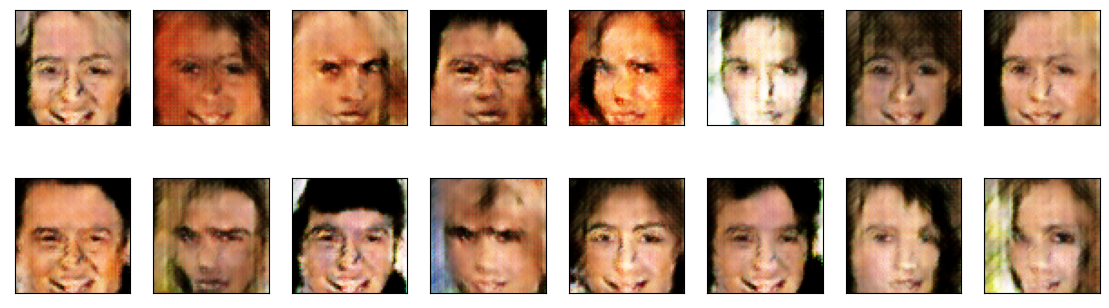

Epoch 8


Training:   1%|▎                                | 3/381 [00:00<00:43,  8.74it/s]

2025-01-15 17:44:29 | Epoch [9/10] | Batch 0/381 | d_loss: 1.0952 | g_loss: 2.8077


Training:  14%|████▌                           | 54/381 [00:02<00:12, 26.97it/s]

2025-01-15 17:44:31 | Epoch [9/10] | Batch 50/381 | d_loss: 1.0899 | g_loss: 2.0849


Training:  28%|████████▌                      | 105/381 [00:04<00:10, 27.21it/s]

2025-01-15 17:44:33 | Epoch [9/10] | Batch 100/381 | d_loss: 1.5334 | g_loss: 2.4865


Training:  41%|████████████▋                  | 156/381 [00:06<00:08, 27.33it/s]

2025-01-15 17:44:34 | Epoch [9/10] | Batch 150/381 | d_loss: 0.9597 | g_loss: 1.5672


Training:  54%|████████████████▌              | 204/381 [00:07<00:06, 27.32it/s]

2025-01-15 17:44:36 | Epoch [9/10] | Batch 200/381 | d_loss: 0.8152 | g_loss: 1.6695


Training:  67%|████████████████████▋          | 255/381 [00:09<00:04, 27.72it/s]

2025-01-15 17:44:38 | Epoch [9/10] | Batch 250/381 | d_loss: 1.1518 | g_loss: 1.5015


Training:  80%|████████████████████████▉      | 306/381 [00:11<00:02, 27.15it/s]

2025-01-15 17:44:40 | Epoch [9/10] | Batch 300/381 | d_loss: 1.0967 | g_loss: 1.7124


Training:  93%|████████████████████████████▊  | 354/381 [00:13<00:00, 27.38it/s]

2025-01-15 17:44:42 | Epoch [9/10] | Batch 350/381 | d_loss: 1.0675 | g_loss: 2.5380


Training: 100%|███████████████████████████████| 381/381 [00:14<00:00, 26.31it/s]


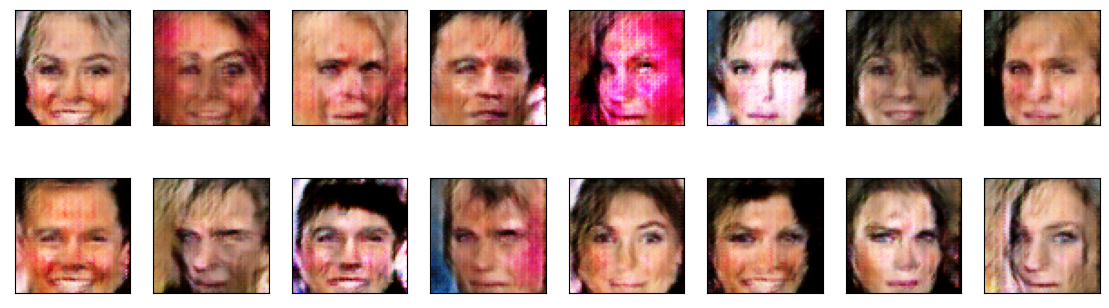

Epoch 9


Training:   1%|▎                                | 4/381 [00:00<00:33, 11.25it/s]

2025-01-15 17:44:48 | Epoch [10/10] | Batch 0/381 | d_loss: 1.2200 | g_loss: 1.8557


Training:  14%|████▌                           | 55/381 [00:02<00:12, 26.61it/s]

2025-01-15 17:44:49 | Epoch [10/10] | Batch 50/381 | d_loss: 1.1782 | g_loss: 1.3762


Training:  28%|████████▌                      | 106/381 [00:04<00:10, 27.23it/s]

2025-01-15 17:44:51 | Epoch [10/10] | Batch 100/381 | d_loss: 1.2581 | g_loss: 2.2619


Training:  40%|████████████▌                  | 154/381 [00:06<00:08, 26.88it/s]

2025-01-15 17:44:53 | Epoch [10/10] | Batch 150/381 | d_loss: 1.3877 | g_loss: 0.9707


Training:  54%|████████████████▋              | 205/381 [00:07<00:06, 26.21it/s]

2025-01-15 17:44:55 | Epoch [10/10] | Batch 200/381 | d_loss: 1.1507 | g_loss: 2.5074


Training:  67%|████████████████████▊          | 256/381 [00:09<00:04, 26.19it/s]

2025-01-15 17:44:57 | Epoch [10/10] | Batch 250/381 | d_loss: 1.1096 | g_loss: 2.2038


Training:  80%|████████████████████████▋      | 304/381 [00:11<00:02, 25.82it/s]

2025-01-15 17:44:59 | Epoch [10/10] | Batch 300/381 | d_loss: 1.2514 | g_loss: 2.0338


Training:  93%|████████████████████████████▉  | 355/381 [00:13<00:01, 25.59it/s]

2025-01-15 17:45:01 | Epoch [10/10] | Batch 350/381 | d_loss: 0.9104 | g_loss: 1.3948


Training: 100%|███████████████████████████████| 381/381 [00:14<00:00, 25.64it/s]


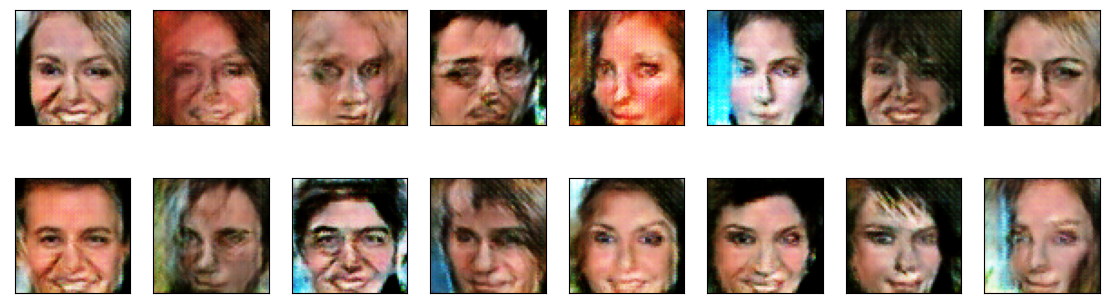

In [70]:
# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().cuda()

losses = []
for epoch in range(n_epochs):
    print(f'Epoch {epoch}')
    for batch_i, (real_images, labels) in tqdm(
        enumerate(dataloader),
        desc="Training",
        total=len(dataloader),
        leave=True,
        ncols=80):

        real_images = real_images.to(device)
        num_images = real_images.size(0)
        
        ############################
        # (1) Train Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        # Zero out gradients of discriminator optimizer's parameters
        d_optimizer.zero_grad()

        # z - latent vector
        # z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        # z = torch.from_numpy(z).float()
        z = torch.randn(num_images, latent_dim, 1, 1).float().to(device)
        fake_images = G(z)

        # don't want to backprop gradients, because want to maximize loss for fake images when training discriminator on them, not minimize
        fake_predictions = D(fake_images.detach())

        # Compute the discriminator's predictions for real and fake data
        real_predictions = D(real_images)

        #gp = gradient_penalty(D, real_images, fake_images)

        #loss = wasserstein_loss(real_predictions, fake_predictions, lambda_gp, gp)
        
        # maximize log(D(x)) + log(1 - D(G(z))) - sum of losses for the all real and fake batches
        d_loss = discriminator_loss(real_predictions, fake_predictions)
        
        d_loss.backward()
        d_optimizer.step()

        ############################
        # (2) Train Generator: maximize log(D(G(z)))
        ###########################

        # Zero out gradients of generator optimizer
        g_optimizer.zero_grad()

        # z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        # z = torch.from_numpy(z).float()
        # generate new sample
        z = torch.randn(num_images, latent_dim, 1, 1).float().to(device)
        fake_images = G(z)
        # run discriminator again
        fake_logits = D(fake_images)

        # maximize log(D(G(z)))
        g_loss = generator_loss(fake_logits)

        g_loss.backward()
        g_optimizer.step()

        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss.item()
            g = g_loss.item()
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')
    
    # display images during training
    G.eval()
    generated_images = G(fixed_latent_vector)
    display(generated_images)
    G.train()

### Training losses

Plot the training losses for the generator and discriminator.

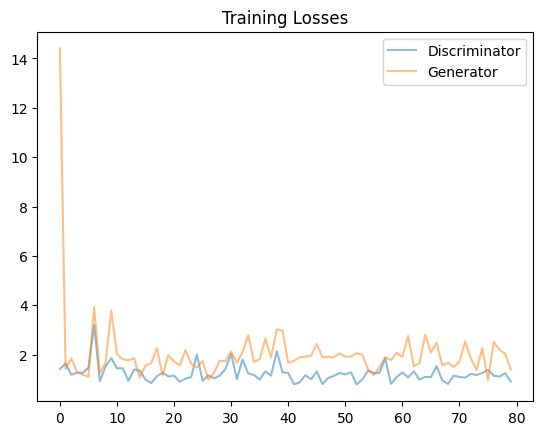

In [71]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:** The final set of faces generated by this GAN resemble the celebrity training images to an extent. In order to generate a set of faces more representative of the world's general population, a bigger variety of faces would have to be included in the training set, rather than just celebrity faces.
The GAN model size is pretty big in terms of the convolutional/latent dimension size that it shoots to, as well as the fact that each network has either 5 convolutional layers or 2d tranpose convolutional layers, with a batch normalization in each as well as optional noise layers for the generator. The model size, however, be increased further if we had images larger than 64x64 which is a rather small resolution. More layers would be needed to handle larger resolution images and the GPUs available would be need to be increased as well.
It was found that RMSProp did not work well as an optimizer; Adam performed significantly better. The default hyperparameter values found on the PyTorch CycleGAN demo for Adam's parameters were used. The number of training epochs should be increased to improve the detail and accuracy of the final set of output images. The BCEWithLogitsLoss function was used since a sigmoid adtivation was not used at the final layer of the discriminator, and the output are logits.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.